In [2]:
import pandas as pd
import numpy as np
import os
from glob import glob
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Folder path where your CSVs are stored
DATA_DIR = 'nifty100_stock_data'  # <-- Replace this


In [3]:
###Loading and combining all the csv files 
def load_all_data(folder_path):
    all_files = glob(os.path.join(folder_path, '*.csv'))
    df_list = []

    for file in all_files:
        symbol = os.path.basename(file).replace('.csv', '')
        df = pd.read_csv(file)
        df['Symbol'] = symbol
        df_list.append(df)

    full_df = pd.concat(df_list, ignore_index=True)
    full_df['Date'] = pd.to_datetime(full_df['Date'])
    full_df.sort_values(by=['Symbol', 'Date'], inplace=True)
    return full_df

df = load_all_data(DATA_DIR)
print("Shape:", df.shape)
df.head()


Shape: (392441, 27)


,Date,Close Price,High Price,Low Price,Open Price,Total Traded Quantity,Symbol,Prev Close,Average Price,SMA_10,...,RSI,Upper_BB,Lower_BB,ATR,ADX,Stochastic,CCI,Lag_10,Lag_50,Lag_200
0,2006-03-29,95.773697,97.301013,95.539352,96.260400,328068.0,ABB.NS_data,96.232544,96.204687,97.428170,...,64.362298,103.968503,85.807704,2.872705,50.249395,44.421976,20.637766,97.328873,65.482971,43.654766
1,2006-03-30,94.570847,96.850355,93.835049,96.679924,1085972.0,ABB.NS_data,95.773697,95.085417,97.055356,...,58.954261,102.871906,88.013901,2.882891,48.392208,9.472556,-9.996483,98.298988,66.172867,42.809162
2,2006-03-31,95.967049,98.028600,94.719958,95.309908,948941.0,ABB.NS_data,94.570847,96.238536,96.895576,...,62.855674,102.076833,89.768299,2.923953,47.083184,29.301611,4.381480,97.564842,66.336746,42.740337
3,2006-04-03,100.570312,101.569954,96.358719,97.276420,820584.0,ABB.NS_data,95.967049,99.499662,97.183669,...,72.228258,101.793907,91.327814,3.115306,46.862119,87.076226,91.998013,97.689392,67.539612,42.953369
4,2006-04-04,101.587975,103.339802,100.783346,102.389325,683448.0,ABB.NS_data,100.570312,101.903708,97.535837,...,73.802082,101.608466,92.768540,3.090605,47.044032,81.568932,177.949025,98.066292,68.876816,43.390919


In [4]:
df['Close_Price_Shift'] = df.groupby('Symbol')['Close Price'].shift(-1)
df['Target'] = df['Close_Price_Shift'] - df['Close Price']
df['Target_pct'] = (df['Target'] / df['Close Price']) * 100


In [5]:
def add_derived_features(df):
    df['Price_vs_SMA10'] = (df['Close Price'] - df['SMA_10']) / df['SMA_10']
    df['Price_vs_EMA50'] = (df['Close Price'] - df['EMA_50']) / df['EMA_50']
    df['Return_1d'] = df.groupby('Symbol')['Close Price'].pct_change(1)
    df['Return_3d'] = df.groupby('Symbol')['Close Price'].pct_change(3)
    df['Return_5d'] = df.groupby('Symbol')['Close Price'].pct_change(5)
    df['RollingStd_5'] = df.groupby('Symbol')['Close Price'].rolling(window=5).std().reset_index(level=0, drop=True)
    return df

df = add_derived_features(df)


In [6]:
df.dropna(inplace=True)
print("Remaining rows after dropping NaNs:", df.shape)


Remaining rows after dropping NaNs: (390903, 36)


In [7]:
FEATURES = [col for col in df.columns if col not in ['Date', 'Symbol', 'Target', 'Target_pct']]
TARGET = 'Target_pct'  # or 'Target'

X = df[FEATURES]
y = df[TARGET]

# Scale features if needed
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [10]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import time

# Start timing
start_time = time.time()

# Train HistGradientBoostingRegressor
print("⏳ Training HistGradientBoostingRegressor...")
model = HistGradientBoostingRegressor(max_iter=100, random_state=42, verbose=1)
model.fit(X_train, y_train)

# End timing
end_time = time.time()
print(f"✅ Training completed in {end_time - start_time:.2f} seconds")

# Predictions
y_pred = model.predict(X_test)

# Evaluation
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print(f"📊 Model Performance:")
print(f" - R² Score: {r2:.4f}")
print(f" - MAE: {mae:.4f}")
print(f" - RMSE: {rmse:.4f}")


⏳ Training HistGradientBoostingRegressor...
Binning 0.072 GB of training data: 2.379 s
Binning 0.008 GB of validation data: 1.267 s
Fitting gradient boosted rounds:
Fit 100 trees in 106.056 s, (3100 total leaves)
Time spent computing histograms: 42.560s
Time spent finding best splits:  23.395s
Time spent applying splits:      29.573s
Time spent predicting:           0.624s
✅ Training completed in 106.08 seconds


TypeError: got an unexpected keyword argument 'squared'

🔍 Calculating permutation feature importances... (this may take a moment)


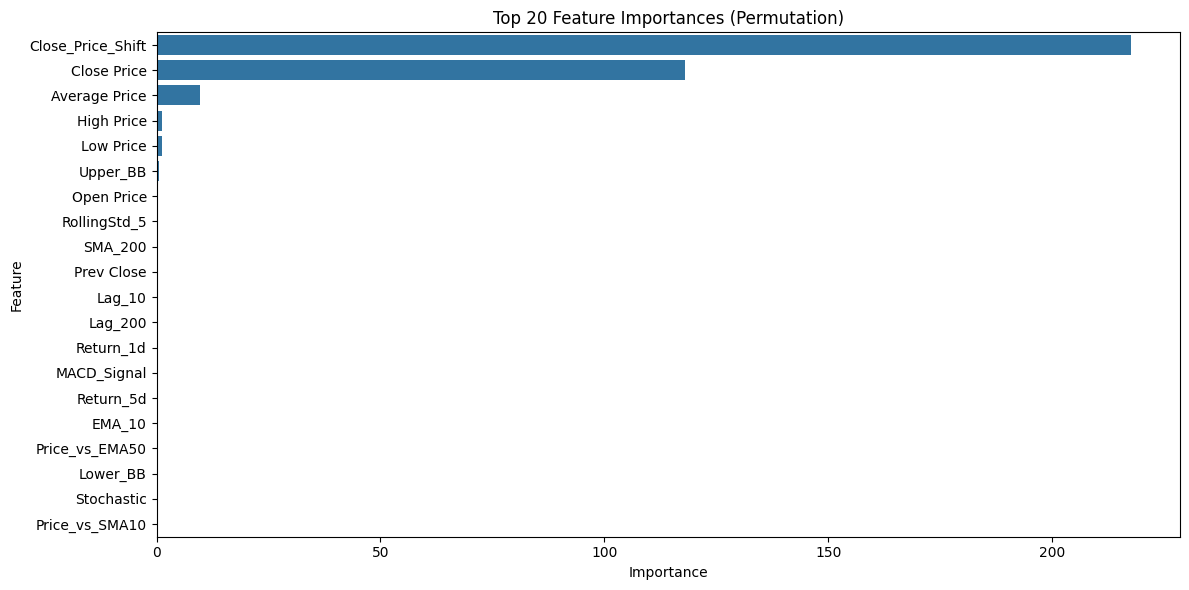

📌 Retained 23 important features.


In [12]:
from sklearn.inspection import permutation_importance

print("🔍 Calculating permutation feature importances... (this may take a moment)")
perm = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=1)

importance_df = pd.DataFrame({
    'Feature': FEATURES,
    'Importance': perm.importances_mean
}).sort_values(by='Importance', ascending=False)

# Plot top 20
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
plt.title("Top 20 Feature Importances (Permutation)")
plt.tight_layout()
plt.show()

# Optionally drop low-importance features
important_features = importance_df[importance_df['Importance'] > 0.001]['Feature'].tolist()
print(f"📌 Retained {len(important_features)} important features.")

# Prepare reduced dataset for future modeling/export
X_important = df[important_features]
X_imp_scaled = scaler.fit_transform(X_important)

# Train/test split again on reduced feature set
X_train, X_test, y_train, y_test = train_test_split(X_imp_scaled, y, test_size=0.2, random_state=42)


In [13]:
# Reassemble final dataframe with important features
final_df = df[['Date', 'Symbol'] + important_features + ['Target', 'Target_pct']]

# Export the final dataframe with important features
final_df.to_csv("nifty100_feature_engineered_important_features.csv", index=False)

print("✅ Dataset saved as 'nifty100_feature_engineered_important_features.csv' with important features.")


✅ Dataset saved as 'nifty100_feature_engineered_important_features.csv' with important features.
